# 1 模型选择、欠拟合和过拟合
通过多项式拟合来交互地探索这些概念

In [9]:
import math
import numpy as np
import torch
from torch import nn, optim
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：

$$
y=5+1.2x-3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+\epsilon\:\text{where}\:\epsilon\sim\mathcal{N}(0,0.1^2)
$$
噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。在优化的过程中，我们通常希望避免非常大的梯度值或损失值。这就是我们将特征从$x^{i}$调整为$\frac{x^i}{i!}$的原因，这样可以避免很大的$i$带来的特别大的指数值。我们将为训练集和测试集各生成100个样本。



In [10]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度：(n_train + n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

前两个样本

In [13]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]

features[:2], poly_features[:2], labels[:2]

(tensor([[-0.2182],
         [ 0.1251]]),
 tensor([[ 1.0000e+00, -2.1820e-01,  2.3805e-02, -1.7314e-03,  9.4446e-05,
          -4.1216e-06,  1.4989e-07, -4.6721e-09,  1.2743e-10, -3.0894e-12,
           6.7410e-14, -1.3372e-15,  2.4314e-17, -4.0809e-19,  6.3603e-21,
          -9.2520e-23,  1.2617e-24, -1.6194e-26,  1.9631e-28, -2.2544e-30],
         [ 1.0000e+00,  1.2510e-01,  7.8248e-03,  3.2629e-04,  1.0205e-05,
           2.5532e-07,  5.3233e-09,  9.5134e-11,  1.4876e-12,  2.0678e-14,
           2.5868e-16,  2.9419e-18,  3.0669e-20,  2.9512e-22,  2.6371e-24,
           2.1993e-26,  1.7196e-28,  1.2654e-30,  8.7944e-33,  5.7903e-35]]),
 tensor([4.7783, 5.1525]))

实现一个函数来评估模型在给定数据集上的损失

In [17]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义损失函数

In [18]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2, ],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 4.9908032  1.2449265 -3.3719692  5.455109 ]]


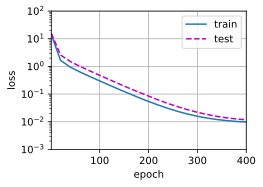

In [19]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数欠拟合

weight: [[3.7764008 2.6916697]]


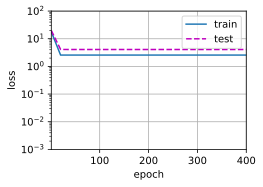

In [21]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 5.0245075   1.4188377  -3.560399    4.667422    0.550888    1.5074215
   0.3243216   0.28594714  0.15893209 -0.12070772 -0.03352502  0.1422315
  -0.21087925 -0.18586822  0.12130873 -0.13957858  0.10864939 -0.10633993
   0.07793102 -0.1545068 ]]


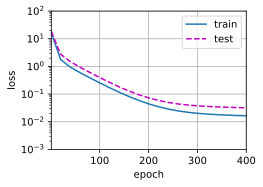

In [23]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:])